# <font color="RoyalBlue">Energy Price Prediction - Introduction</font>

This project is part of a university course and focuses on <b>predicting electricity prices</b> using Python and Jupyter Notebooks. For now, only the hourly <b>EPEX SPOT day-ahead prices of germany</b> are covered. After a quick data analysis, several machine learning and time series models (SARIMA, Prophet, XGBoost, LSTM) are trained, evaluated and finally compared.

Table of Contents of this Notebook:
1) Importing Libraries
2) Loading the Data
3) Merging the Data Frames
4) Exploratory Data Analysis (EDA)
5) Data Preparation
6) Feature Engineering
7) Model Training and Prediction
8) Model Evaluation and Comparison
9) Conclusion

## <font color="RoyalBlue">1 Importing Libraries</font>
Import all necessary libraries required for data analysis, machine learning models and data visualization. This is also where we can set a plot design applied for Seaborn and Pyplot.

In [1584]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Time Series Models
from xgboost import XGBRegressor
import xgboost as xgb
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Scikit-Learn Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Holidays
import holidays

# Time and Date
import datetime

# Simple plot design
print(plt.style.available)
sns.set_style('darkgrid')
sns.set_palette("bright")


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## <font color="RoyalBlue">2 Loading the Data</font>

First of all, let's load the data of the csv files into this project. We use several csv files and later merge them together into just one dataframe by using their time information. Before merging, we take a brief look at each data frame and remove unnecessary information. Moreover, we need to overcome some challenges, such as converting data types and handling the german daylight saving time change.

The first data set contains the hourly EPEX Spot prices and looks as follows:


In [1585]:
df_prices = pd.read_csv("../data/germany_epex_spot.csv")
df_prices.head()

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe)
0,Germany,DEU,2015-01-01 00:00:00,2015-01-01 01:00:00,22.34
1,Germany,DEU,2015-01-01 01:00:00,2015-01-01 02:00:00,22.34
2,Germany,DEU,2015-01-01 02:00:00,2015-01-01 03:00:00,22.34
3,Germany,DEU,2015-01-01 03:00:00,2015-01-01 04:00:00,22.34
4,Germany,DEU,2015-01-01 04:00:00,2015-01-01 05:00:00,22.34


We can obviously remove the columns "Country", "ISO3 Code" and "Datetime (UTC)" because they wont be needed for the model training. With regard to merging the individual dataframes later, we will also rename the time-related column that represent our primary key to "timestamp". Furthermore, we need to convert this timestamp to a valid datetime type.

In [1586]:
# Rename some Columns
df_prices = df_prices.rename(columns={
    'Datetime (Local)': 'timestamp',
    'Price (EUR/MWhe)': 'price_eur_per_mwh'
})

# Only keep relevant Columns
df_prices = df_prices[['timestamp', 'price_eur_per_mwh']]

# Convert data type from string to datetime64[ns]
df_prices['timestamp'] = pd.to_datetime(df_prices['timestamp'])

# Show our data
df_prices.head()

,timestamp,price_eur_per_mwh
0,2015-01-01 01:00:00,22.34
1,2015-01-01 02:00:00,22.34
2,2015-01-01 03:00:00,22.34
3,2015-01-01 04:00:00,22.34
4,2015-01-01 05:00:00,22.34


The next data set contains information about the energy consumption and includes hourly forecasts for the demanded net load and residual load. The net load represents the total electricity demand at a given time, including all consumers. The residual load refers the the remaining electricity demand that must be met by controllable power plants after subtracting generation from renewable sources like wind and solar. The dataframe looks like this:

In [1587]:
df_consumption = pd.read_csv("../data/energy_consumption_forecast.csv", delimiter=";")
df_consumption.head()

,Date from,Date to,Forecast Netload[MWh],Forecast Residual Load[MWh]
0,01.01.2015 00:00,01.01.2015 01:00,"49.306,25","41.399,00"
1,01.01.2015 01:00,01.01.2015 02:00,"46.952,50","38.481,50"
2,01.01.2015 02:00,01.01.2015 03:00,"45.751,50","37.152,25"
3,01.01.2015 03:00,01.01.2015 04:00,"45.306,25","36.638,50"
4,01.01.2015 04:00,01.01.2015 05:00,"45.423,00","36.580,50"


Just like with the first dataframe, we can remove unnecessary columns and rename others. Because this is a German data set, we will also need to convert the decimal values into the correct format so that we can work with actual float values.

In [1588]:
# Rename some columns
df_consumption = df_consumption.rename(columns={
    'Date from': 'timestamp',
    'Forecast Netload[MWh]': 'forecast_net_load_mwh',
    'Forecast Residual Load[MWh]': 'forecast_residual_load_mwh'
})

# Get rid of unnecessary "Date to" column
df_consumption.drop(columns=['Date to'], inplace=True)

df_consumption['timestamp'] = pd.to_datetime(df_consumption['timestamp'], format="%d.%m.%Y %H:%M")

# TODO: Convert float format to correct format

df_consumption.head()

,timestamp,forecast_net_load_mwh,forecast_residual_load_mwh
0,2015-01-01 00:00:00,"49.306,25","41.399,00"
1,2015-01-01 01:00:00,"46.952,50","38.481,50"
2,2015-01-01 02:00:00,"45.751,50","37.152,25"
3,2015-01-01 03:00:00,"45.306,25","36.638,50"
4,2015-01-01 04:00:00,"45.423,00","36.580,50"


Finally, we will also use data containing hourly forecasts for energy generation. These include solar, wind and others:

In [1589]:
df_generation = pd.read_csv("../data/power_generation_forecast.csv", delimiter=";")
df_generation.head()

,Date from,Date until,Forecast Total [MWh],Forecast Wind and Solar [MWh],Forecast Wind Offshore [MWh],Forecast Wind Onshore [MWh],Forecast Solar [MWh],Forecast Other Sources [MWh]
0,01.01.2015 00:00,01.01.2015 01:00,"58.974,00","7.907,25","258,50","7.648,75","0,00","51.066,75"
1,01.01.2015 01:00,01.01.2015 02:00,"57.681,00","8.471,00","258,75","8.212,25","0,00","49.210,00"
2,01.01.2015 02:00,01.01.2015 03:00,"56.256,00","8.599,25","258,50","8.340,75","0,00","47.656,75"
3,01.01.2015 03:00,01.01.2015 04:00,"54.432,00","8.667,75","259,00","8.408,75","0,00","45.764,25"
4,01.01.2015 04:00,01.01.2015 05:00,"54.522,00","8.842,50","260,50","8.582,00","0,00","45.679,50"


There is of course some work to be done here as well, just like to before. This includes removing and renaming some columns as well as converting data types.

In [1590]:
# Remove unnecessary Columns
df_generation = df_generation.drop(columns=[
    "Date until",
    "Forecast Wind and Solar [MWh]"
])

# Rename Columns
df_generation = df_generation.rename(columns={
    'Date from': 'timestamp',
    'Forecast Total [MWh]': 'forecast_total_mwh',
    'Forecast Wind Offshore [MWh]': 'forecast_wind_offshore_mwh',
    'Forecast Wind Onshore [MWh]': 'forecast_wind_onshore_mwh',
    'Forecast Solar [MWh]': 'forecast_solar_mwh',
    'Forecast Other Sources [MWh]': 'forecast_other_mwh'
})

# Convert timstamp to datetime type
df_generation['timestamp'] = pd.to_datetime(df_generation['timestamp'], format="%d.%m.%Y %H:%M")

# TODO: Convert float format to correct format


df_generation.head()

,timestamp,forecast_total_mwh,forecast_wind_offshore_mwh,forecast_wind_onshore_mwh,forecast_solar_mwh,forecast_other_mwh
0,2015-01-01 00:00:00,"58.974,00","258,50","7.648,75","0,00","51.066,75"
1,2015-01-01 01:00:00,"57.681,00","258,75","8.212,25","0,00","49.210,00"
2,2015-01-01 02:00:00,"56.256,00","258,50","8.340,75","0,00","47.656,75"
3,2015-01-01 03:00:00,"54.432,00","259,00","8.408,75","0,00","45.764,25"
4,2015-01-01 04:00:00,"54.522,00","260,50","8.582,00","0,00","45.679,50"


## <font color="RoyalBlue">3 Merging the Data Frames</font>

After loading in the data, creating our dataframes and preparing them, we are now theoretically ready to merge them together into just one single dataframe. However, before that, make sure that each dataframes timestamp column is valid to be merged on. We'll see that this is not the case right now!

In [1591]:
# Make sure that we have a common timestamp column
common_columns = set(df_generation.columns).intersection(df_consumption.columns).intersection(df_prices.columns)
print("Common columns between all dataframes:", common_columns)

# Let's also make sure that the data type of each timestamp is valid
print("Data type df_prices['timestamp']:", df_prices['timestamp'].dtype)
print("Data type df_generation['timestamp']:", df_generation['timestamp'].dtype)
print("Data type df_consumption['timestamp']:", df_consumption['timestamp'].dtype)

# Check if timestamp is NaN anywhere
print("df_prices has {} timestamp values that are NaN".format(df_prices['timestamp'].isna().sum()))
print("df_generation has {} timestamp values that are NaN".format(df_generation['timestamp'].isna().sum()))
print("df_consumption has {} timestamp values that are NaN".format(df_consumption['timestamp'].isna().sum()))

# Print the amount of common timestamp values
common_values = set(df_generation['timestamp']).intersection(df_consumption['timestamp']).intersection(df_prices['timestamp'])
print("Common values between all dataframes:", len(common_values))

# Check for any timestamp duplicates -> Daylight Saving Time Change!?
print(df_prices[df_prices.duplicated(subset='timestamp')])
print(df_generation[df_generation.duplicated(subset='timestamp')])
print(df_consumption[df_consumption.duplicated(subset='timestamp')])


Common columns between all dataframes: {'timestamp'}
Data type df_prices['timestamp']: datetime64[ns]
Data type df_generation['timestamp']: datetime64[ns]
Data type df_consumption['timestamp']: datetime64[ns]
df_prices has 0 timestamp values that are NaN
df_generation has 0 timestamp values that are NaN
df_consumption has 0 timestamp values that are NaN
Common values between all dataframes: 87661
                timestamp  price_eur_per_mwh
7129  2015-10-25 02:00:00              25.02
16033 2016-10-30 02:00:00              31.55
24769 2017-10-29 02:00:00             -83.00
33505 2018-10-28 02:00:00              44.06
42241 2019-10-27 02:00:00             -10.38
50977 2020-10-25 02:00:00              -6.39
59881 2021-10-31 02:00:00              58.26
68617 2022-10-30 02:00:00              95.29
77353 2023-10-29 02:00:00               7.58
86089 2024-10-27 02:00:00              68.62
                timestamp forecast_total_mwh forecast_wind_offshore_mwh  \
7130  2015-10-25 02:00:00     

### Note on Duplicate Timestamps (Daylight Saving Time)

As seen above, the datasets contain exactly one duplicate timestamp at Hour 02:00 on the last Sunday of October every year. This occurs due to the end of Daylight Saving Time in Germany, when clocks are set back one hour. As a result, the hour between 02:00 and 03:00 appears twice. These duplicate timestamps need to be handled accordingly, for example by using timezone-aware timestamps, removing duplicates, or differentiating them manually. For this project, it is sufficient to just remove these "duplicates".

In [1592]:
# Remove duplicates that result from daylight saving time
df_prices = df_prices[~df_prices.duplicated(subset='timestamp')]
df_generation = df_generation[~df_generation.duplicated(subset='timestamp')]
df_consumption = df_consumption[~df_consumption.duplicated(subset='timestamp')]

# Check if there are duplicates left
print("Amount of duplicates in df_prices:", df_prices['timestamp'].duplicated().sum())
print("Amount of duplicates in df_generation:", df_generation['timestamp'].duplicated().sum())
print("Amount of duplicates in df_consumption:", df_consumption['timestamp'].duplicated().sum())

Amount of duplicates in df_prices: 0
Amount of duplicates in df_generation: 0
Amount of duplicates in df_consumption: 0


We are now ready to merge all dataframes into one and set the index to timestamp:

In [1593]:
# Now merge the dataframes
df = pd.merge(
    df_prices,
    df_consumption,
    on='timestamp',
    how='inner'
)

df = pd.merge(
    df,
    df_generation,
    on='timestamp',
    how='inner'
)

# Set timetamp as index
df = df.set_index("timestamp")
df = df.sort_index()

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87661 entries, 2015-01-01 01:00:00 to 2024-12-31 23:00:00
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   price_eur_per_mwh           87661 non-null  float64
 1   forecast_net_load_mwh       87661 non-null  object 
 2   forecast_residual_load_mwh  87661 non-null  object 
 3   forecast_total_mwh          87661 non-null  object 
 4   forecast_wind_offshore_mwh  87661 non-null  object 
 5   forecast_wind_onshore_mwh   87661 non-null  object 
 6   forecast_solar_mwh          87661 non-null  object 
 7   forecast_other_mwh          87661 non-null  object 
dtypes: float64(1), object(7)
memory usage: 6.0+ MB


It is best to quickly check if the merge was valid. This is because even if the merge runs without errors, issues like misaligned timestamps, unexpected duplicates, or missing data can lead to incorrect results or inconsistencies in the dataset.  

In [ ]:
# Check if merge is valid
common_timestamps = set(df_prices['timestamp']) & set(df_consumption['timestamp']) & set(df_generation['timestamp'])
print("Expected number of rows:", len(common_timestamps))
print("Actual number of rows:", len(df))

# Check for missing values in each column
print("\nAmount of missing values per column:")
print(df.isna().sum())

# Check the data types
print("\nData types:", df.dtypes)


Expected number of rows: 87661
Actual number of rows: 87661

Amount of missing values per column:
price_eur_per_mwh             0
forecast_net_load_mwh         0
forecast_residual_load_mwh    0
forecast_total_mwh            0
forecast_wind_offshore_mwh    0
forecast_wind_onshore_mwh     0
forecast_solar_mwh            0
forecast_other_mwh            0
dtype: int64

Data types: price_eur_per_mwh             float64
forecast_net_load_mwh          object
forecast_residual_load_mwh     object
forecast_total_mwh             object
forecast_wind_offshore_mwh     object
forecast_wind_onshore_mwh      object
forecast_solar_mwh             object
forecast_other_mwh             object
dtype: object


Now it's time to add some more features and lags to our dataframe

<Axes: title={'center': 'Data Frame'}, xlabel='timestamp'>

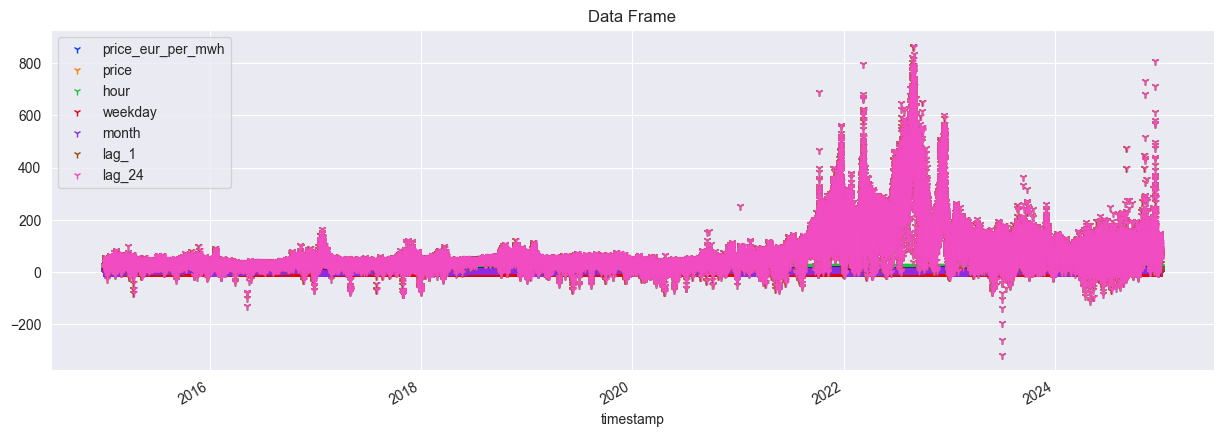

In [1595]:
# TODO: overhaul all of this

# convert local time in datetime object and set as index
df_prices["timestamp"] = pd.to_datetime(df_prices["timestamp"])
df_prices = df_prices.set_index("timestamp")
df_prices = df_prices.sort_index()

# target variable
df_prices["price"] = df_prices["price_eur_per_mwh"]

# time based features
df_prices["hour"] = df_prices.index.hour
df_prices["weekday"] = df_prices.index.weekday
df_prices["month"] = df_prices.index.month

# lag features (price 1h and 24h before)
df_prices["lag_1"] = df_prices["price"].shift(1)
df_prices["lag_24"] = df_prices["price"].shift(24)
# TODO: maybe more? What is best?

df_prices.plot(style="1", figsize=(15, 5), title="Data Frame")


Print out some basic information about our data

In [1596]:
df_prices.head()
# df.tail()
# df.describe()
# df.dtypes
# df.info()
# df.shape()
# df.count()
# df.min()
# df.max()

# TODO: do this for all our data frames when new data sets are available

,price_eur_per_mwh,price,hour,weekday,month,lag_1,lag_24
timestamp,,,,,,,
2015-01-01 01:00:00,22.34,22.34,1,3,1,NaN,NaN
2015-01-01 02:00:00,22.34,22.34,2,3,1,22.34,NaN
2015-01-01 03:00:00,22.34,22.34,3,3,1,22.34,NaN
2015-01-01 04:00:00,22.34,22.34,4,3,1,22.34,NaN
2015-01-01 05:00:00,22.34,22.34,5,3,1,22.34,NaN


TODO: explain negative electricity prices very briefly here and print some examples

## <font color="RoyalBlue">3 Exploratory Data Analysis (EDA)</font>
In this section, we explore and visualize the data to better understand patterns and correlation. This is done before handling NaN values and outliers.

TODO: add small summary for each plot
- Price over Time
- Correlation of the featuers (maybe with sns.heatmap)
- Plot and explain seasonal patterns
- Plot the target variable over time
- Boxplot
- more ... ?

### Price over Time

In [1597]:
# TODO: plot price over time

### Correlation of the features

In [1598]:
# TODO: sns.heatmap()

## <font color="RoyalBlue">4 Data Preparation</font>
This section prepares the data by handling missing values, removing duplicates and transforming data types (TODO: remove last part of sentence if no transformation needed later). This is also a good place to remove unnecessary features that may have a negative impact on the models prediction.

In [1599]:
# remove rows with NaN (because of shift)

nan_amount_before = 20 # TODO -> df.isna().sum()
print("amount of NaN values before cleanup: {}".format(nan_amount_before))
df_prices = df_prices.dropna()
nan_amount_after = 0 # TODO
print("amount of NaN values after cleanup: {}".format(nan_amount_after))

nan_amount_removed = nan_amount_before - nan_amount_after
print("So we removed {} NaN values".format(nan_amount_removed))


amount of NaN values before cleanup: 20
amount of NaN values after cleanup: 0
So we removed 20 NaN values


TODO: maybe scaling / normalising needed for numerical features?

In [1600]:
# TODO: scale or normalize values if this achieves better performance

## <font color="RoyalBlue">5 Feature Engineering</font>
Here, we can use our conclusions of the EDA by defining our feature set and the target variable that is to predict. In this regard, we will also create some new features that can be used for training in order to gain a better performance out of the models.

Lastly, we split our data into train and test data. Note, that when using time series data like we do, we should not split randomly, but by date instead.

TODO: maybe explain the term "lags"

In [1601]:
# Create some new features

# TODO: calendar features (hour, weekday, month)
# TODO: add holiday features

In [1602]:
# Define feature set and target variable 
features = ["hour", "weekday", "month", "lag_1", "lag_24"] # lags used for 
X = df_prices[features]
y = df_prices["price"]

Now we split our data into train and test data. We need to make sure that the data is not split randomly, but instead chronologically, so that the model is trained on past data and tested on future data only. This avoids so called "Data Leakage".

In this case, we split by 80:20 for Training and Test data.

In [1603]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# For X_train
print("X_train:")
print("  Lines:", len(X_train))
print("  Span:", X_train.index.min(), "until", X_train.index.max())

# For X_test
print("X_test:")
print("  Lines:", len(X_test))
print("  Span:", X_test.index.min(), "Span", X_test.index.max())

# For y_train
print("y_train:")
print("  Lines:", len(y_train))
print("  Span:", y_train.index.min(), "Span", y_train.index.max())

# For y_test
print("y_test:")
print("  Lines:", len(y_test))
print("  Span:", y_test.index.min(), "Span", y_test.index.max())

X_train:
  Lines: 70110
  Span: 2015-01-02 01:00:00 until 2023-01-01 14:00:00
X_test:
  Lines: 17528
  Span: 2023-01-01 15:00:00 Span 2025-01-01 00:00:00
y_train:
  Lines: 70110
  Span: 2015-01-02 01:00:00 Span 2023-01-01 14:00:00
y_test:
  Lines: 17528
  Span: 2023-01-01 15:00:00 Span 2025-01-01 00:00:00


## <font color="RoyalBlue">6 Model Training and Prediction</font>
In this section, we ... TODO

TODO: use different data for each model (SARIMA, Prophet, XGBoost, LSTM)?

TODO: add a section for each model

### Create and train model (only XGBRegressor for now)

In [1604]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

### Predict and evaluate

In [1605]:
y_pred = model.predict(X_test)

# TODO: do evaluation in section 7 below 
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f} EUR/MWh")

RMSE: 12.94 EUR/MWh


## <font color="RoyalBlue">7 Model Evaluation and Comparison</font>
TODO: add description

Plot real prices against the predicted prices for each model (probably best to do this in one plot only)

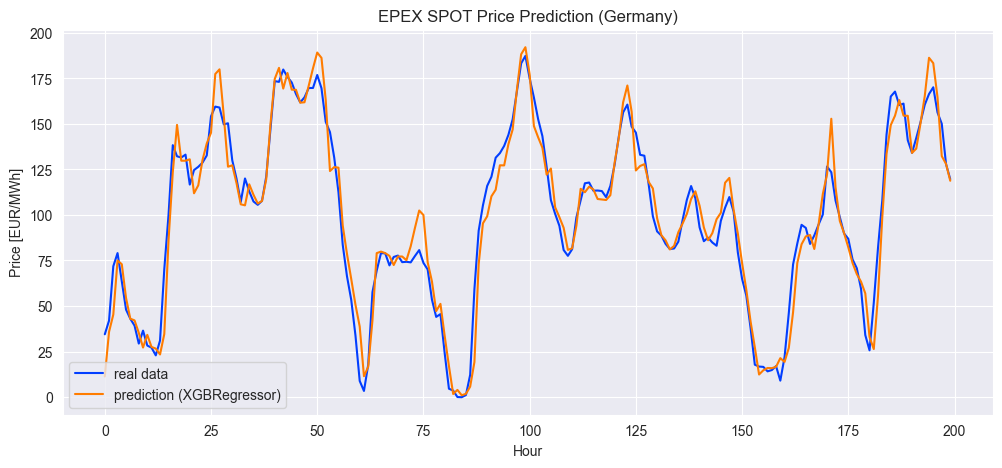

In [1606]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:200], label="real data")
plt.plot(y_pred[:200], label="prediction (XGBRegressor)")
plt.legend()
plt.title("EPEX SPOT Price Prediction (Germany)")
plt.xlabel("Hour")
plt.ylabel("Price [EUR/MWh]")
plt.show()

TODO: Print relevant evaluation metrics for eacht model (MAE, RMSE, MAPE) and explain them briefly.


## <font color="RoyalBlue">8 Conclusion</font>
TODO: add:
- which model performs the best? Why? 
- What errors / short cuts may have been made in this project? How does it impact the outcome?
- do certain models show specific weaknesses (for example especially bad predictions on holidays)